In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score

N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

# past is encoded
past_tense = open("wickle_train/ed1000.txt", 'r').read().strip().split()
words = [pt[:len(pt)-2] for pt in past_tense]

test_past_tense = past_tense[:100]
test_words = words[:100]

past_tense = past_tense[100:]
words = words[100:]


RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

def encode(s, RI, cluster_size=3):
    s = "#"+s+"."
    #global RI
    #global N
    #global D
    #global alphabet
    z = np.zeros(N)
    count = 0
    for i in range(len(s)-cluster_size):
        count += 1
        l = np.ones(N)
        for j in s[i:i+cluster_size]:
            l = np.multiply(RI[alphabet.index(j), :], l)
            l = np.roll(l, 1)
        z += l

    return 2*(z + 0.1*(np.random.rand(N) - 0.5) > 0) - 1#np.where(z/count > 0, 1, -1)

def encodes(words, past_tense):
    seen = []
    for i in range(len(words)):
        enc = encode(words[i], RI_pres, 3)
        enc_past = encode(past_tense[i], RI_past, 3)
        seen.append((enc, enc_past))
    #plt.figure()
    #plt.plot(enc[:50])
    #print enc.shape
    return seen

def map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def perceptron_map_train(encoded):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        # if predict correctly, add to total_vec with a smaller weight
        train_pred, random_pred = predict(total_vec, [encoded[i]])
        if train_pred > random_pred:
            total_vec += ((N-train_pred)/float(N)) * np.multiply(encoded[i][0], encoded[i][1])
        else:
            total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def predict(model, encoded):
    data1, data3 = np.zeros(len(encoded)), np.zeros(len(encoded))
    total1, total3, count = 0, 0, 0
    
    random_vecs = np.random.randn(len(encoded), N)
    
    for j in range(len(encoded)):
        pair = encoded[j]
        sim1 = np.dot(np.multiply(model, pair[0]), pair[1])
        total1 += sim1

        sim3 = np.dot(np.multiply(model, random_vecs[j,:]), pair[0])
        total3 += sim3

        count += 1
        data1[j] = sim1 #total1/float(count)
        data3[j] = sim3 #total3/float(count)

    return data1, data3

def graph(train_func, encoded, test_encoded):
    test_m = np.arange(1, len(encoded), 1)

    train_dot = np.zeros_like(test_m)
    test_dot = np.zeros_like(test_m) # np.zeros(test_m.shape)
    random_dot = np.zeros_like(test_m)

    for im, m in enumerate(test_m):
        map_model = train_func(encoded[:int(m)])
        d1, d3 = predict(map_model, encoded[:int(m)])
        d2, d4 = predict(map_model, test_encoded)
        train_dot[im] = d1.mean()
        test_dot[im] = d2.mean()
        random_dot[im] = d3.mean()

    plt.figure()
    plt.plot(test_m, train_dot)
    plt.plot(test_m, random_dot)
    plt.plot(test_m, test_dot)
    plt.show()


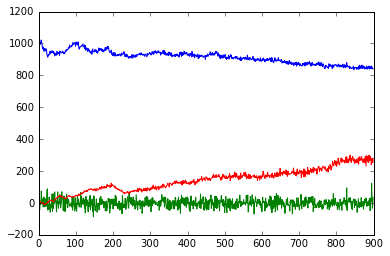

In [4]:
encoded = encodes(words, past_tense)
test_encoded = encodes(test_words, test_past_tense)

#graph(perceptron_map_train, encoded, test_encoded)

In [17]:
from __future__ import division

from pylab import *
import scipy
import time

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [24]:
"""
Xhat1 = 2 terms. the first step, 
the hats can be random (sum of all possible letters-all letters 
have uniform probablity)
Xhatrest = 3 terms.
-make an estimator for each Xhati. then can decode
-ran over and over. may have to worry about how many letters you have.
-the more iterations the better the prediction. so the next letters will be decoded correctly with a higher probability. every iteration this is going to get more refined. an iteration is definited as the calculation for Xhat (over entire word) - have to know how many letters you have.
-paxon’s non linearity is the clipping. apply clipping.
"""
def encode_Xhat(Xhat, cluster_size=3):
    z = np.zeros(N)
    for i in range(len(s)-cluster_size):
        l = np.ones(N)
        for j in s[i:i+cluster_size]:
            l = np.multiply(Xhat[j], l)
            l = np.roll(l, 1)
        z += l

    return 2*(z + 0.1*(np.random.rand(N) - 0.5) > 0) - 1

def map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

"""
really we could decode either or. I chose past
"""
present, past = words[0], past_tense[0]
x = encode(past, RI_past, cluster_size=3)
Xhat = np.zeros((len(past), N))
Xhat[:] = np.sum(RI_past)
C = encode_Xhat(Xhat, cluster_size=3)
"""
we know that the encoded word is past, so we're going to check 
similarity at every iteration
"""
num_iters = 10
test_m = np.arange(1, num_iters, 1)
train_dot = np.zeros_like(test_m)
random_dot = np.zeros_like(test_m)
random_vecs = np.random.randn(num_iters, N)
for im, m in enumerate(test_m):
    for i in range(1,Xhat.shape(0)):
        if i == 1:
            Xhat[i] = np.roll(x, 1)*(#*C*np.roll(Xhat[i+1], 2))+
            x*(C*Xhat[i-1]*np.roll(Xhat[i+1], 2))+
            Xhat[i]
        else:
            Xhat[i] = np.roll(x, 1)*(C*Xhat[i-1]*np.roll(Xhat[i],1))*np.roll(Xhat[i+1],2))+
                x*(C*np.roll(Xhat[i-1],1)*np.roll(Xhat[i+1],2))+
                x*(C*np.roll(Xhat[i+1],2)*np.roll(Xhat[i+2],3))+
                Xhat[i]
    pred = encode_Xhat(Xhat)
    train_dot[im] = x.dot(pred)
    random_dot[im] = x.dot(random_vecs[im,:])
    C -= encode_Xhat(Xhat, cluster_size=3)

plt.figure()
plt.plot(test_m, train_dot)
plt.plot(test_m, random_dot)
plt.show()

SyntaxError: invalid syntax (<ipython-input-24-f27f98316157>, line 51)

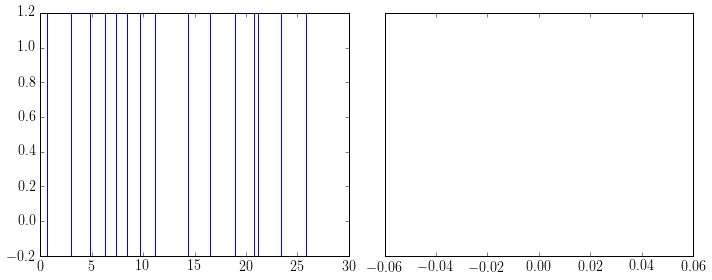

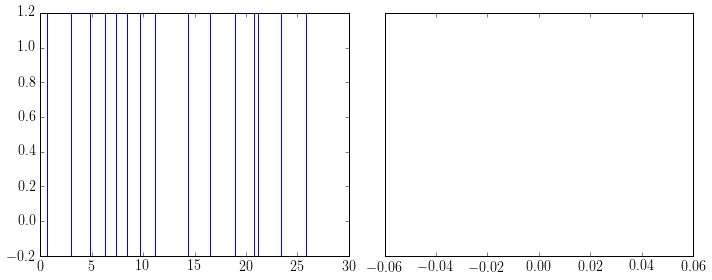

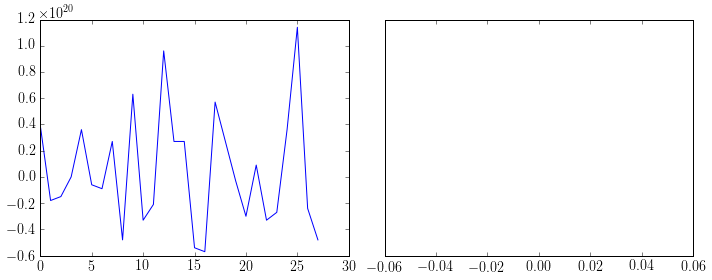

In [20]:
N = 1000
"""
We are going to set up two sets of symbols -- one set that, say, 
represents objects (obj_vecs) 26 letters + # + .
and another that represents transformations (trf_vecs) - 
although i think our transformations are different. i think it's just 1 or 2 transformations 
    -roll, clip
"""
objD = 28
obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
"""
What we expect is that symbols chosen from each set are bound together by multiplication, 
and the goal is to find the original two vectors. So in this case, recover the first trigram.
"""
present, past = words[0], past_tense[0]
# bc it's just an -ed verb lol
encoded_present = encode(present[:2], obj_vecs, cluster_size=3)
encoded_past = encode(present[:2], obj_vecs, cluster_size=3)
trf_vec = map_train([encoded_present, encoded_past])
bound_vec = encoded_present * trf_vec

x_coef = np.dot(obj_vecs, trf_vec.sum(axis=0) * bound_vec)
t_coef = np.dot(trf_vec, obj_vecs.sum(axis=0) * bound_vec)

"""
We can now decode the result and figure out the original vectors that were bound together.
Fucked up.
"""
figure(figsize=(10,4))

subplot(121)
plot(x_coef * N)
ylim([-0.2, 1.2])

subplot(122)
plot(t_coef * N)
ylim([-0.2, 1.2])
yticks([])

plt.tight_layout()

xc_sum = np.dot(N*x_coef.T, obj_vecs) # our new guess is based on the coefficients from the frist step
tc_sum = np.dot(N*t_coef.T, trf_vec)
x_coef2 = np.dot(obj_vecs, tc_sum * bound_vec)
t_coef2 = np.dot(trf_vec, xc_sum * bound_vec)

figure(figsize=(10,4))

subplot(121)
plot(x_coef2 * N)
ylim([-0.2, 1.2])

subplot(122)
plot(t_coef2 * N)
ylim([-0.2, 1.2])
yticks([])

plt.tight_layout()

xc_sum = np.dot(N*x_coef2.T, obj_vecs)
tc_sum = np.dot(N*t_coef2.T, trf_vec)
x_coef2 = np.dot(obj_vecs, tc_sum * bound_vec)
t_coef2 = np.dot(trf_vec, xc_sum * bound_vec)

figure(figsize=(10,4))

subplot(121)
plot(x_coef2 * N)

subplot(122)
plot(t_coef2 * N)
yticks([])

plt.tight_layout()

In [ ]:
# Resonance Attractors for Unbinding Inference
# uhhhh